In [29]:
import pytplot
from pytplot import tplot, options  , store_data, options, data_quants, netcdf_to_tplot, xlim
import xarray as xr
import numpy as np
import pyspedas
import pandas as pd

In [48]:
def variable_maker(mag_spec=None, mag_line=None, orb=None, window=1024, shift=1):
    """
    Args:
        # tplot変数の作成
        # pytplot, pyspedas, netcdf4などのモジュールが必要
        # mag_spec: スペクトルデータのnetcdfファイルのパス
        # mag_line: 磁場データのnetcdfファイルのパス
        # orb: 軌道データのnetcdfファイルのパス
        # window: スペクトル解析の窓幅
        # shift: スペクトル解析のシフト幅

    return:
        labels 軌道ラベル
        生成されているtplot変数
            'para' : 平行方向の磁場振動成分のスペクトル
            'perp' : 垂直方向の磁場振動成分のスペクトル
            'norm' : 合計の磁場振動成分のスペクトル
            'ratio' : 垂直方向と平行方向の比率のスペクトル
            'mag_rot_perp' : 垂直方向の磁場振動成分
            'mag_rot_para' : 平行方向の磁場振動成分
            'mag_norm' : 合計の磁場振動成分
            'cyc_freq' : サイクロトロン周波数 ['H+', 'H2+', 'O+', 'O2+', 'S+', 'OH+', 'H2O+', 'SO+', 'SO2+']
            'para_cyc' : 平行方向の磁場振動成分のスペクトルにサイクロトロン周波数を重ねたもの
            'perp_cyc' : 垂直方向の磁場振動成分のスペクトルにサイクロトロン周波数を重ねたもの
            'norm_cyc' : 合計の磁場振動成分のスペクトルにサイクロトロン周波数を重ねたもの
            'ratio_cyc' : 垂直方向と平行方向の比率のスペクトルにサイクロトロン周波数を重ねたもの

    plot_sample:
        tplot(['para', 'perp', 'norm', 'ratio', 'mag_norm', 'mag_rot_perp', 'mag_rot_para', 'cyc_freq'], var_label=labels, xsize=12, ysize=18)
        サイクロトロン周波数を重ねたいものに変更する場合は
        tplot(['para_cyc', 'perp_cyc', 'norm_cyc', 'ratio_cyc'], var_label=labels, xsize=12, ysize=18)
    """


    if mag_spec is not None:
        dataset = xr.open_dataset(mag_spec, engine="netcdf4")

        para = dataset["para_{}_{}".format(window, shift)]
        perp = dataset["perp_{}_{}".format(window, shift)]
        norm = dataset["norm_{}_{}".format(window, shift)]
        ratio = dataset["ratio_{}_{}".format(window, shift)]

        v_dim = para.v.values

        store_data('para', data={'x': para.time , 'y': para.values, 'v': v_dim})
        store_data('perp', data={'x': perp.time , 'y': perp.values, 'v': v_dim})
        store_data('norm', data={'x': norm.time , 'y': norm.values, 'v': v_dim})
        store_data('ratio', data={'x': ratio.time , 'y': ratio.values, 'v': v_dim})

        yrange = [para.v.values[1], para.v.values[-1]]

        options(f'para', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_para', 'Colormap': 'jet', 'yrange': yrange})
        options(f'perp', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_perp', 'Colormap': 'jet', 'yrange': yrange})
        options(f'norm', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_norm', 'Colormap': 'jet', 'yrange': yrange})
        options(f'ratio', opt_dict={'zlog': False, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': 'Ratio', 'ytitle': 'perp/para', 'Colormap': 'Greys', 'yrange': yrange, 'zrange': [0, 10]})

    if mag_line is not None:
        dataset = xr.open_dataset(mag_line, engine="netcdf4")

        mag_norm = dataset["juno_mag_norm"]
        mag_rot_perp = dataset["juno_mag_rot_perp"]
        mag_rot_para = dataset["juno_mag_rot_para"]
        cyc_freq = dataset["juno_cyc_freq"]

        store_data('mag_norm', data={'x': mag_norm.time , 'y': mag_norm.values})
        store_data('mag_rot_perp', data={'x': mag_rot_perp.time , 'y': mag_rot_perp.values})
        store_data('mag_rot_para', data={'x': mag_rot_para.time , 'y': mag_rot_para.values})
        store_data('cyc_freq', data={'x': cyc_freq.time , 'y': cyc_freq.values})

        label = ['H+', 'H2+', 'O+', 'O2+', 'S+', 'OH+', 'H2O+', 'SO+', 'SO2+']
        options('mag_norm', opt_dict={'ylog': 1, 'ytitle': 'Total B', 'ysubtitle': '[$nT$]'})#,
        options('mag_rot_perp', opt_dict={'ylog': 1, 'ytitle': 'MFA B Perp', 'ysubtitle': '[$nT$]'})#,
        options('mag_rot_para', opt_dict={'ylog': 1, 'ytitle': 'MFA B Para', 'ysubtitle': '[$nT$]'})#,
        #options('cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':2, 'linestyle': '-'})#,
                                            #'Color': ['red', 'red', 'green', 'green', 'black', 'blue', 'blue', 'purple', 'purple']})
        mh = 1.67262192369 * 1e-27
        mh2 = 1.6737 * 1e-27 * 2

        mo = 2.6567 * 1e-26
        mo2 = 2.6567 * 1e-26 * 2

        ms = 5.324 * 1e-26

        moh = mo + mh
        moh2 = mo + mh2

        mso = ms + mo
        mso2 = ms + mo2

        q = 1.60217662 * 1e-19

        b = pytplot.data_quants['mag_norm']

        label = ['H+', 'H2+', 'O+', 'O2+', 'S+', 'OH+', 'H2O+', 'SO+', 'SO2+']

        cyc_data = np.zeros((len(b['time']), 9))
        cyc_data[:,0] = 1 / (2 * np.pi) * q * b * 1e-9 / mh
        cyc_data[:,1] = 1 / (2 * np.pi) * q * b * 1e-9 / mh2
        cyc_data[:,2] = 1 / (2 * np.pi) * q * b * 1e-9 / mo
        cyc_data[:,3] = 1 / (2 * np.pi) * q * b * 1e-9 / mo2
        cyc_data[:,4] = 1 / (2 * np.pi) * q * b * 1e-9 / ms
        cyc_data[:,5] = 1 / (2 * np.pi) * q * b * 1e-9 / moh
        cyc_data[:,6] = 1 / (2 * np.pi) * q * b * 1e-9 / moh2
        cyc_data[:,7] = 1 / (2 * np.pi) * q * b * 1e-9 / mso
        cyc_data[:,8] = 1 / (2 * np.pi) * q * b * 1e-9 / mso2

        store_data('cyc_freq', data={'x': b['time'], 'y': cyc_data})
        options('cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':1.5, 'linestyle': '-', 'legend_names':label, 'alpha' :0.6})#,


    if orb is not None:
        dataset = xr.open_dataset(orb, engine="netcdf4")

        rclatsys3lt = dataset['juno_orbit_rclatsys3lt']

        store_data('rclatsys3lt', data={'x': rclatsys3lt.time , 'y': rclatsys3lt.values})
        labels = pytplot.split_vec('rclatsys3lt')
        options('rclatsys3lt_0', opt_dict={'ytitle': 'R[Rj]'})
        options('rclatsys3lt_1', opt_dict={'ytitle': 'CLat[deg]'})
        options('rclatsys3lt_2', opt_dict={'ytitle': 'Sys3[deg]'})
        options('rclatsys3lt_3', opt_dict={'ytitle': 'LT[hours]'})

    if mag_spec is not None and mag_line is not None:
        store_data('para_cyc', data=['para', 'cyc_freq', 'para'])
        store_data('perp_cyc', data=['perp', 'cyc_freq', 'perp'])
        store_data('norm_cyc', data=['norm', 'cyc_freq', 'norm'])
        store_data('ratio_cyc', data=['ratio', 'cyc_freq', 'ratio'])

    return labels

In [49]:
labels = variable_maker(mag_spec=mag_spec, mag_line=mag_line, orb=orb, window=window, shift=shift)

In [50]:
def plot(star_hour = None, end_hour = None, spec_only = None):
    """
    Args:
        tplot変数のプロット
        star_hour: プロット開始時間
        end_hour: プロット終了時間
        spec_only: スペクトルのみプロットする場合はTrue
        star_hour, end_hourがNoneの場合は1日分のデータをプロット
        star_hourのみ指定した場合は3時間分のデータをプロット

    return:
        tplot変数のプロット
    """
    data_array = data_quants['rclatsys3lt']['time'][10]
    date_only = data_array.dt.strftime('%Y-%m-%d').values
    if star_hour is None and end_hour is None:
        if spec_only is None:
            tplot(['para_cyc', 'perp_cyc', 'norm_cyc', 'ratio_cyc'], var_label=labels, xsize=12, ysize=24)
        else:
            tplot(['para', 'perp', 'norm', 'ratio'], var_label=labels, xsize=12, ysize=24)
    if star_hour is not None and end_hour is not None:
        tr_star = date_only + 'T' + str(star_hour) + ':00:00'
        tr_end = date_only + 'T' + str(end_hour) + ':00:00'
        if spec_only is None:
            xlim(tr_star, tr_end)
            tplot(['para_cyc', 'perp_cyc', 'norm_cyc', 'ratio_cyc'], var_label=labels, xsize=12, ysize=24)
        else:
            xlim(tr_star, tr_end)
            tplot(['para', 'perp', 'norm', 'ratio'], var_label=labels, xsize=12, ysize=24)
    if star_hour is not None and end_hour is None:
        end_hour = star_hour + 3
        tr_star = date_only + 'T' + str(star_hour) + ':00:00'
        tr_end = date_only + 'T' + str(end_hour) + ':00:00'
        if spec_only is None:
            xlim(tr_star, tr_end)
            tplot(['para_cyc', 'perp_cyc', 'norm_cyc', 'ratio_cyc'], var_label=labels, xsize=12, ysize=24)
        else:
            xlim(tr_star, tr_end)
            tplot(['para', 'perp', 'norm', 'ratio'], var_label=labels, xsize=12, ysize=24)

19-Jun-24 16:32:05: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:423: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  xaxis_ticks_dt = [np.datetime64(mpl.dates.num2date(tick_val).isoformat()) for tick_val in xaxis_ticks]

19-Jun-24 16:32:05: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:618: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill

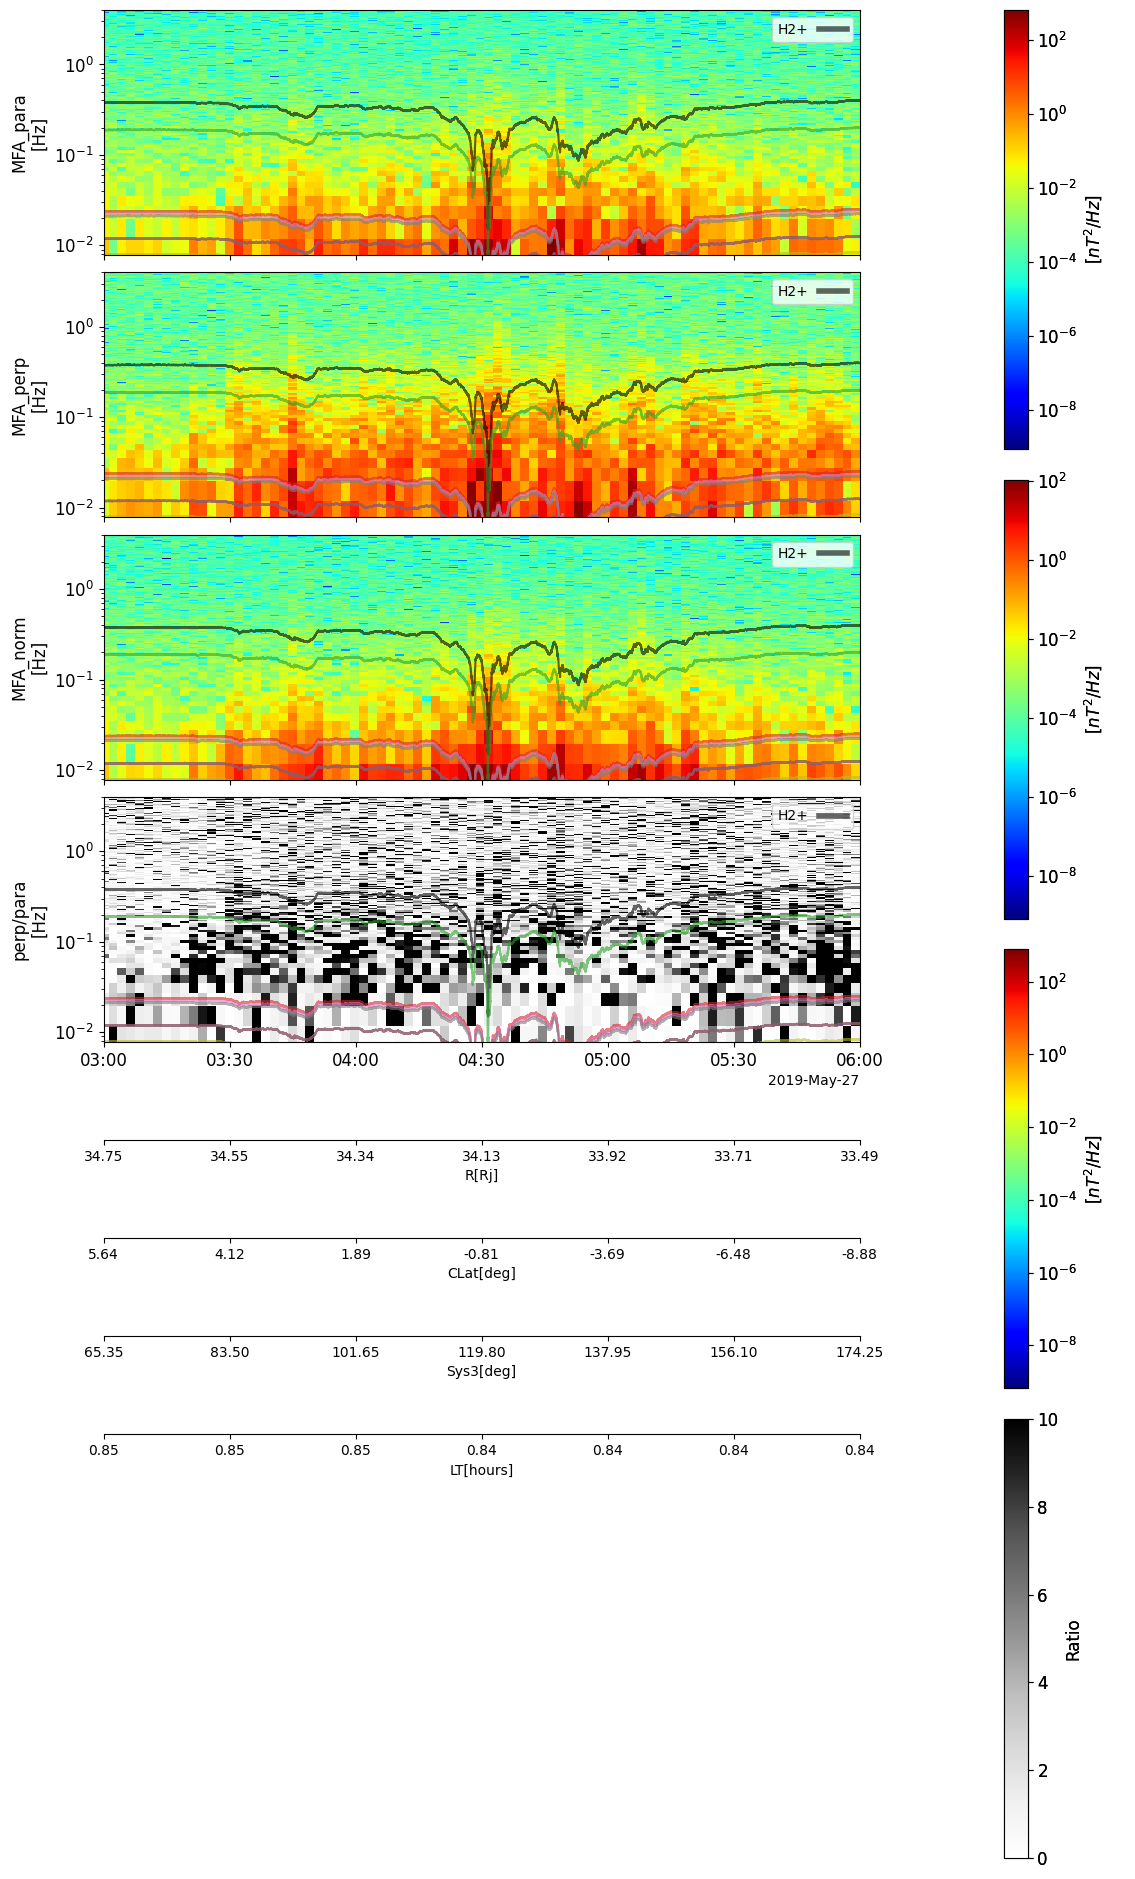

In [51]:
plot(star_hour=3)

19-Jun-24 16:15:53: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:423: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  xaxis_ticks_dt = [np.datetime64(mpl.dates.num2date(tick_val).isoformat()) for tick_val in xaxis_ticks]

19-Jun-24 16:15:53: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:618: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill

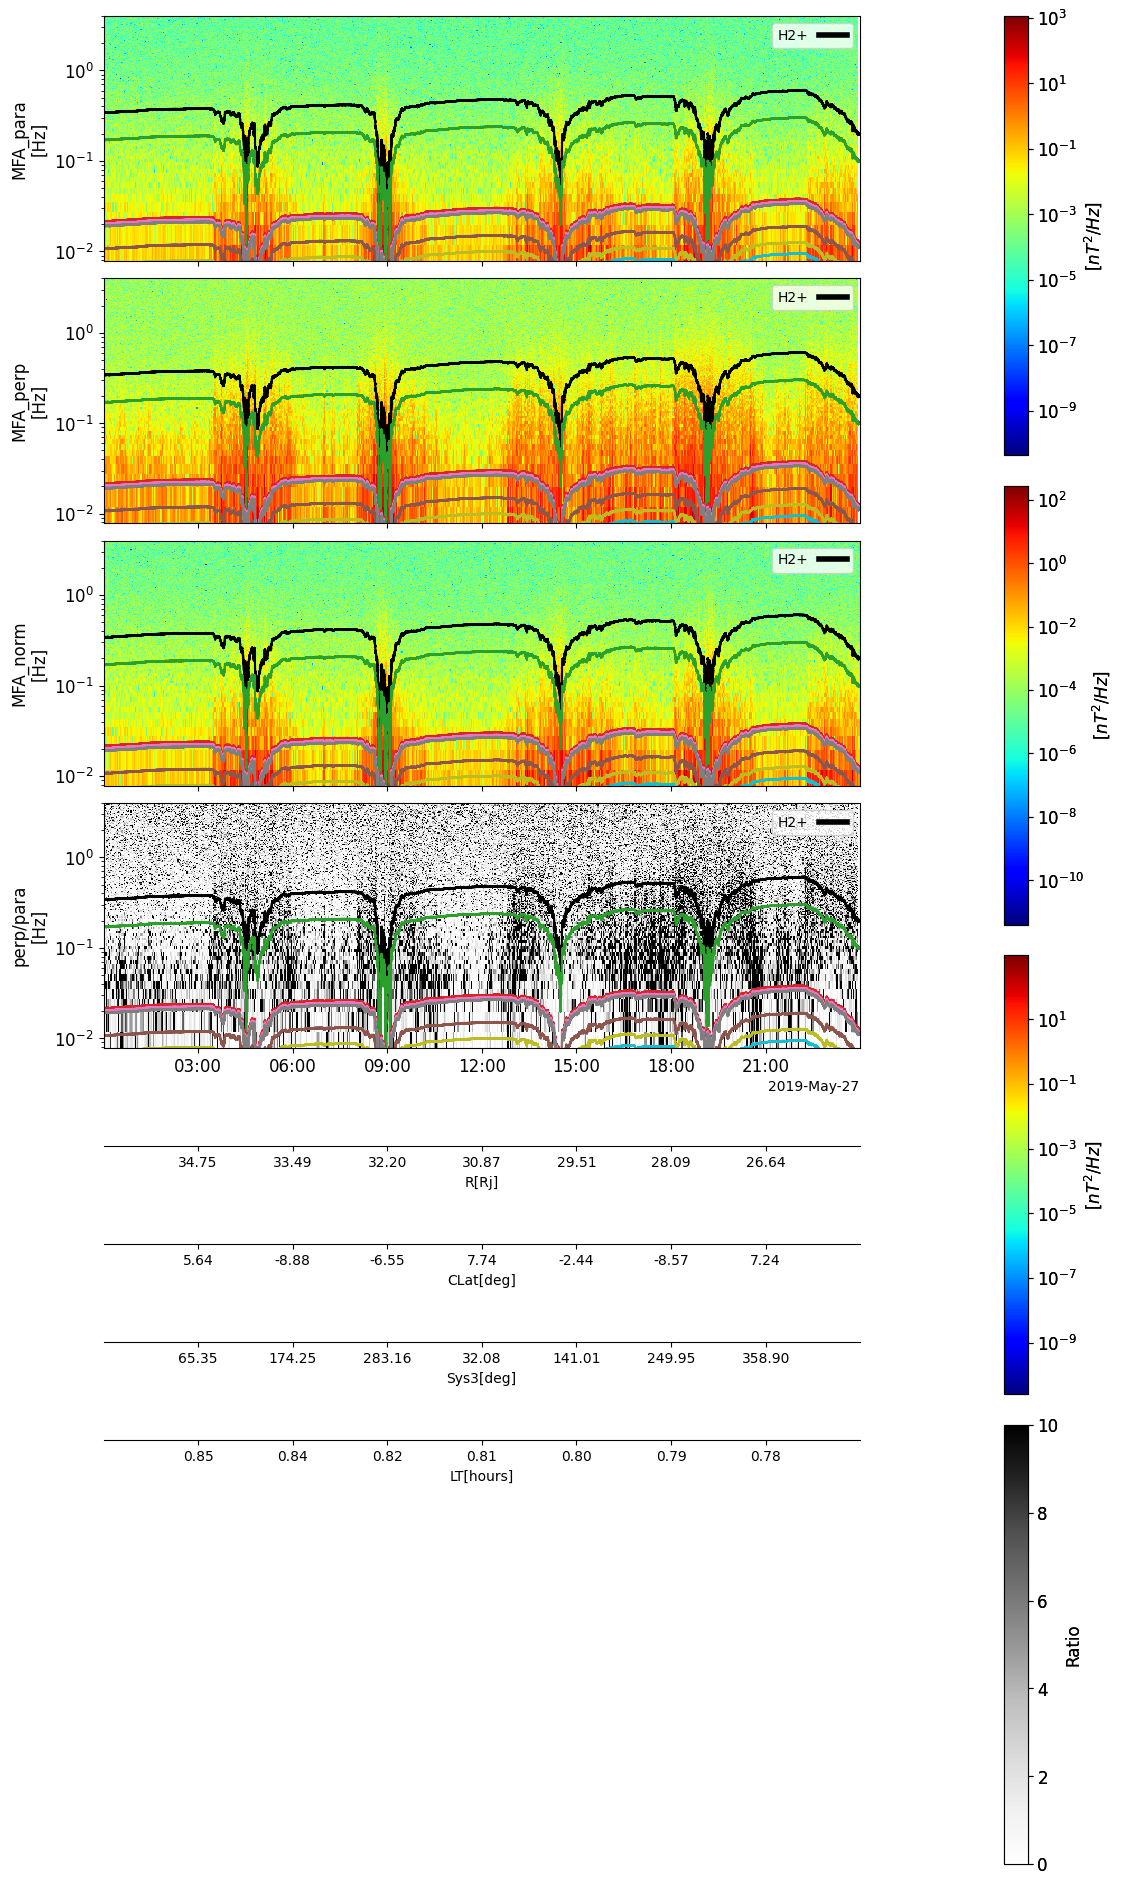

In [26]:
plot()

In [21]:
date = '20190527'
window = '1024'
shift = '1'

year = date[:4]
month = date[4:6]
day = date[6:8]

mag_spec = '/mnt/d/Juno_xarray/mag_spec/{}/{}/spec{}_para_perp_norm_ratio_{}-{}-{}.nc'.format(year, month, window, year, month, day)
mag_line = '/mnt/d/Juno_xarray/mag_line/{}/{}/mag_norm_perp_para_{}-{}-{}.nc'.format(year, month, year, month, day)
orb = '/mnt/d/Juno_xarray/orb/{}/{}/orbit_rclatsys3lt_{}-{}-{}.nc'.format(year, month, year, month, day)

In [22]:
labels = variable_maker(mag_spec=mag_spec, mag_line=mag_line, orb=orb, window=window, shift=shift)

19-Jun-24 16:07:57: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:423: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  xaxis_ticks_dt = [np.datetime64(mpl.dates.num2date(tick_val).isoformat()) for tick_val in xaxis_ticks]

19-Jun-24 16:07:57: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:618: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill

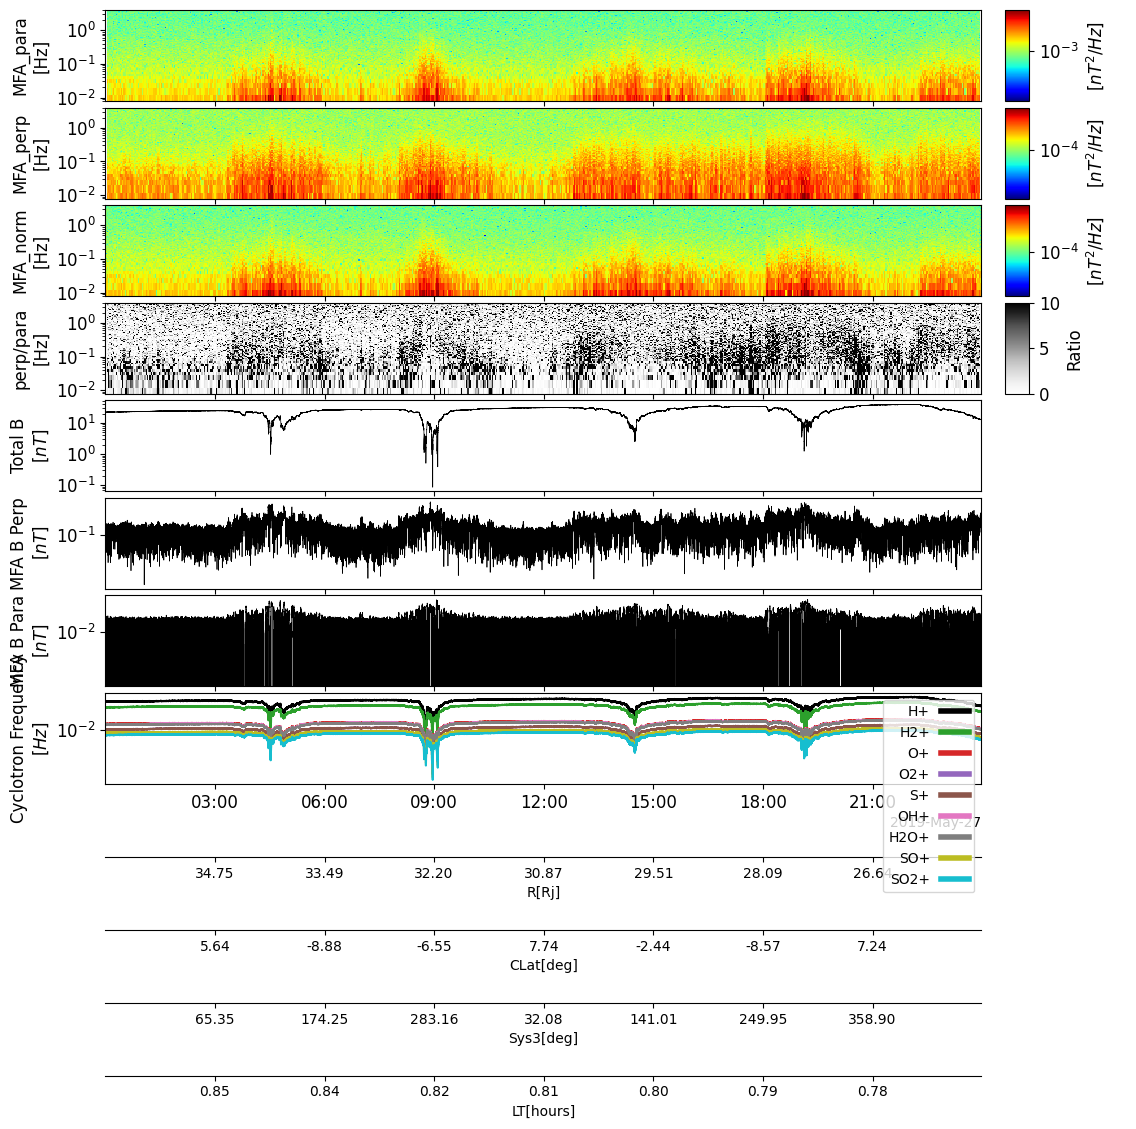

In [12]:
tplot(['para', 'perp', 'norm', 'ratio', 'mag_norm', 'mag_rot_perp', 'mag_rot_para', 'cyc_freq'], var_label=labels, xsize=12, ysize=18)

19-Jun-24 15:33:29: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:423: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  xaxis_ticks_dt = [np.datetime64(mpl.dates.num2date(tick_val).isoformat()) for tick_val in xaxis_ticks]

19-Jun-24 15:33:29: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:618: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill

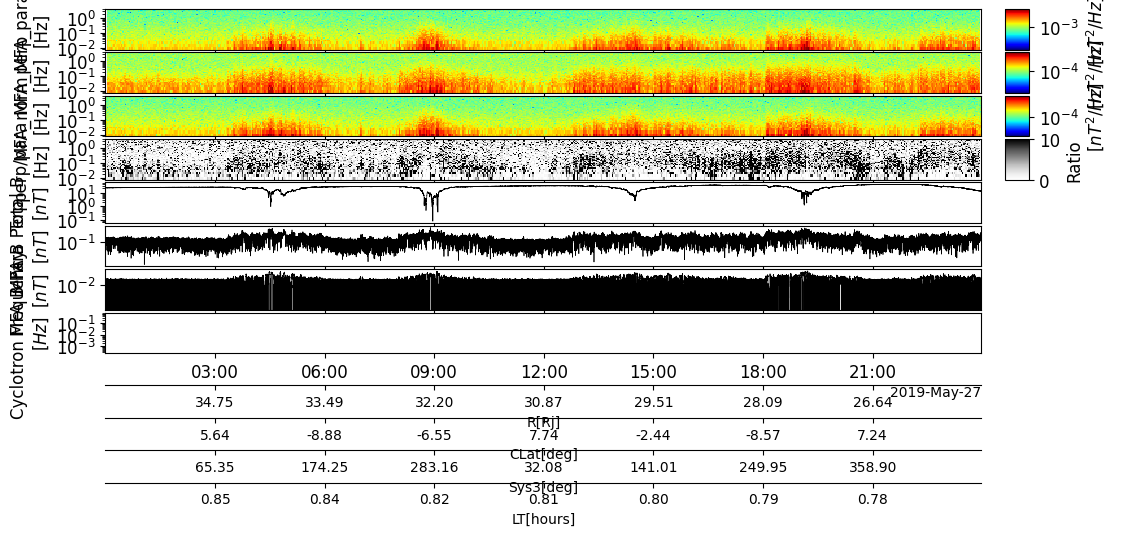

In [52]:
tplot(['para', 'perp', 'norm', 'ratio', 'mag_norm', 'mag_rot_perp', 'mag_rot_para', 'cyc_freq'], var_label=labels)


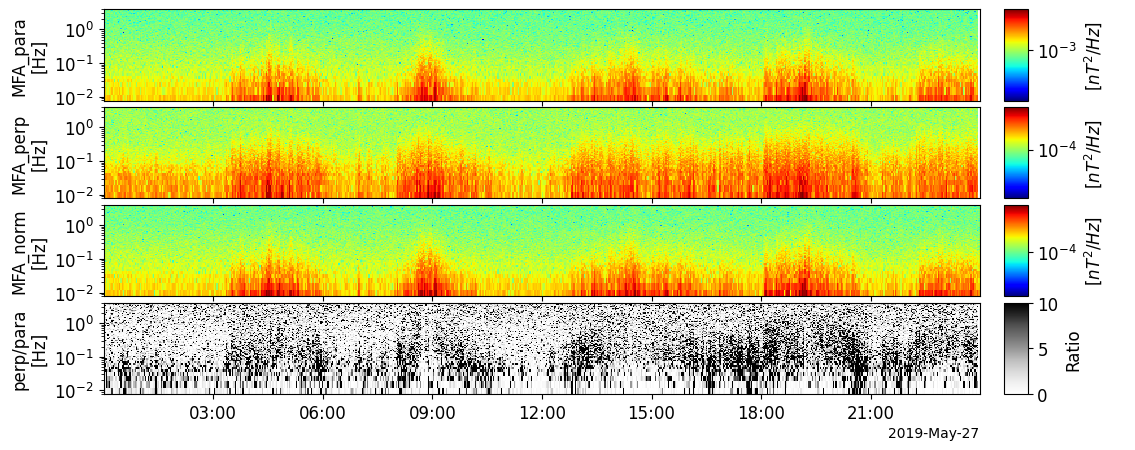

In [36]:
tplot(['para', 'perp', 'norm', 'ratio'])